# Cell type perturbation modeling with GNNs

This notebook relies on the trained GNN models from `train_gnn_model.py` (for model trained with train set and evaluated on test set) and `train_full_gnn_model.py` (for model trained on all data). It performs the gain of function (GOF) and loss of function (LOF) in silico cell type perturbation experiments.

**Associated manuscript figures/tables:**
- Figures: 4j,k,l


**Inputs required:**
- `results/gnn/aging_100per_2hop_2C0aug_200delaunay_celltypeFeat_TN/balanced_mse_1en04/all_model.pth` - PyTorch model corresponding to fully trained GNN with specified parameters (generated from `train_full_gnn_model.py`)
- `data/gnn_datasets/aging_100per_2hop_2C0aug_200delaunay_celltypeFeat_TN/` - directory containing dataset files in the format specified in SpatialAgingCellDataset (in `aging_gnn_model.py` and generated from `train_full_gnn_model.py`)

**Conda environment used**: `requirements/merfish_gnn.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal
import copy

import random

from aging_gnn_model import *

import networkx as nx

import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import k_hop_subgraph, one_hot, to_networkx
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, SAGEConv, global_mean_pool, global_add_pool, global_max_pool
from torch.nn.modules.loss import _Loss

In [1]:
# function for performing in silico cell type perturbation

def perturb_cell_type (data, celltype, get_age=True, get_region=True):
    '''
    Takes in a SpatialAgingCellDataset and perturbs the center cell
    (i.e. ablate and replace with new cell type)
    
    Performs connected_component deconstruction to handle batched graphs.
    
    Arguments:
        data - SpatialAgingCellDataset containing the following:
               data.x - torch tensor indicating node features (starting with cell type one-hot encoding)
               data.edge_index - torch tensor indicating edges
        celltype [str] - cell type for perturbation
        get_age, get_region [bool] - whether to retrieve these labels for metadata
    
    Returns:
        datac - SpatialAgingCellDataset with cell perturbation
        metadata [dict] - graph-level metadata
    '''
    celltypes_to_index = {
         'Neuron-Excitatory' : 0,
         'Neuron-Inhibitory' : 1,
         'Neuron-MSN' : 2, 
         'Astrocyte' : 3, 
         'Microglia' : 4, 
         'Oligodendrocyte' : 5, 
         'OPC' : 6,
         'Endothelial' : 7, 
         'Pericyte' : 8, 
         'VSMC' : 9, 
         'VLMC' : 10,
         'Ependymal' : 11, 
         'Neuroblast' : 12, 
         'NSC' : 13,  
         'Macrophage' : 14, 
         'Neutrophil' : 15,
         'T cell' : 16, 
         'B cell' : 17,
        }
    
    # make copy of graph
    datac = copy.deepcopy(data)
    
    # connected components to get center idxs
    center_idxs = []
    metadata = {}
    metadata["original_center_cells"] = []
    if get_age:
        metadata["age"] = []
    if get_region:
        metadata["region"] = []
    
    # convert to networkx
    datag = to_networkx(datac, to_undirected=True)
    
    for g in (datag.subgraph(c) for c in nx.connected_components(datag)):
        
        # get center cell
        center_idx = nx.center(g)[0]
        center_idxs.append(center_idx)
        
        # track original center cell type
        ct_idx = np.where(datac.x[center_idx,:len(celltypes_to_index.keys())]==1)[0][0]
        metadata["original_center_cells"].append(list(celltypes_to_index.keys())[ct_idx])
        
        # get additional metadata
        if get_age:
            metadata["age"].append(datac.x[center_idx,len(celltypes_to_index.keys())].detach().numpy())
        if get_region:
            reg_idx = np.where(datac.x[center_idx,-4:]==1)[0][0]
            metadata["region"].append(["CC/ACO","CTX","STR","VEN"][reg_idx])
        
    # ablate and inject new cell type
    datac.x[np.array(center_idxs),:len(celltypes_to_index.keys())] = 0
    datac.x[np.array(center_idxs),celltypes_to_index[celltype]] = 1
    
    return (datac, metadata)

## Load model and datasets

In [3]:
# get params
k_hop = 2
augment_hop = 2
center_celltypes = ["T cell","NSC"]
node_feature = "celltype"
loss = "balanced_mse"
learning_rate = 0.0001
use_model = "model"

#--------------------------------------------------------------

# init test data
test_dataset = SpatialAgingCellDataset(subfolder_name="test",
                                       target="aging",
                                       k_hop=k_hop,
                                       augment_hop=augment_hop,
                                       node_feature=node_feature,
                                       num_cells_per_ct_id=100,
                                       center_celltypes=center_celltypes,
                                  use_ids=["11","33",
                                           "57","93"])

# init train data
train_dataset = SpatialAgingCellDataset(subfolder_name="train",
                                        target="aging",
                                        k_hop=k_hop,
                                        augment_hop=augment_hop,
                                        node_feature=node_feature,
                                        num_cells_per_ct_id=100,
                                        center_celltypes=center_celltypes,
                                use_ids=['1','101','14','19','30','38','42',
                                         '46','53','61','7','70','75','80',
                                         '86','97'])

# concatenate datasets
all_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# define data loaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
all_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# LOAD MODELS
model_dirname = loss+f"_{learning_rate:.0e}".replace("-","n")
save_dir = os.path.join("results/gnn",train_dataset.processed_dir.split("/")[-2],model_dirname)

# TRAIN MODEL
# init model
model = GNN(hidden_channels=16,
            input_dim=int(test_dataset.get(0).x.shape[1]),
            method="GIN", pool="add", num_layers=k_hop)

# load model weights
model.load_state_dict(torch.load(os.path.join(save_dir, f"{use_model}.pth")))

# ALL MODEL
# init model
all_model = GNN(hidden_channels=16,
            input_dim=int(test_dataset.get(0).x.shape[1]),
            method="GIN", pool="add", num_layers=k_hop)

# load model weights
all_model.load_state_dict(torch.load(os.path.join(save_dir, f"all_{use_model}.pth")))

<All keys matched successfully>

## Perturbation (Swap in Cell Type) -- Gain of Function

In [ ]:
# INJECT CELL TYPES
celltypes = ["NSC","Endothelial","T cell"]
data_loader = all_loader
model = all_model

has_age = False
has_region = False


#----------------------------------
model.eval()

regions_to_index = {
     'CC/ACO': 0, 
     'CTX': 1, 
     'STR': 2,
     'VEN': 3,
     }

for celltype in celltypes:
    # Make predictions and perturbations
    preds_original = []
    preds_perturbed = []
    actuals = []
    original_celltypes = []
    ages = []
    regions = []

    for data in data_loader:

        # original
        out = model(data.x, data.edge_index, data.batch)
        preds_original.append(out)

        # perturbed
        datac, metadata = perturb_cell_type(data, celltype, get_age=has_age, get_region=has_region)

        out_pert = model(datac.x, datac.edge_index, datac.batch)
        preds_perturbed.append(out_pert)
        original_celltypes.append(metadata["original_center_cells"])

        # label
        actuals.append(data.y.float())

        # metadata
        if has_age:
            ages.append(metadata["age"])
        if has_region:
            regions.append(metadata["region"])

    # concatenate results
    preds_original = np.concatenate([pred.detach().numpy() for pred in preds_original]).flatten()
    preds_perturbed = np.concatenate([pred.detach().numpy() for pred in preds_perturbed]).flatten()
    actuals = np.concatenate([act.detach().numpy() for act in actuals]).flatten()
    original_celltypes = np.concatenate(original_celltypes)
    if has_age:
        ages = np.concatenate(ages).flatten()
    if has_region:
        regions = np.concatenate(regions)

    # save dataframe of results
    df = pd.DataFrame([])
    df["neighborhood_aging"] = actuals
    df["predicted_original"] = preds_original
    df["predicted_perturbed"] = preds_perturbed
    df["celltype_original"] = original_celltypes
    df["celltype_perturbed"] = celltype
    if has_age:
        df["age"] = ages
    if has_region:
        df["region"] = regions

    df.to_csv(f"results/gnn/{train_dataset.processed_dir.split('/')[-2]}_perturbed{celltype}.csv")

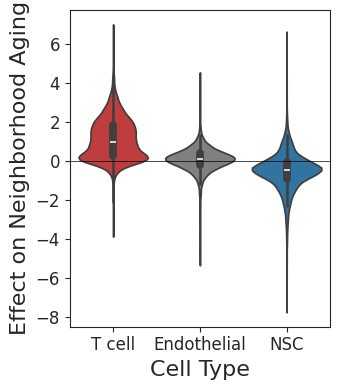

In [12]:
# final plot
celltypes = ["T cell", "Endothelial","NSC"]
palette = {
    "T cell": "tab:red",
    "Endothelial": "0.5",
    "NSC": "tab:blue"
}

#-----------------------------------------------------
pert_effects_col = []
celltype_col = []

for celltype in celltypes:
    
    # read in data
    fn = f"results/gnn/{train_dataset.processed_dir.split('/')[-2]}_perturbed{celltype}.csv"
    df = pd.read_csv(fn)
    
    # exclude unperturbed networks
    df = df[df["celltype_original"]!=df["celltype_perturbed"]]
    
    # compute perturbation effect
    df["perturbation_effect"] = df["predicted_perturbed"]-df["predicted_original"]
    pert_effects_col.append(df["perturbation_effect"].values)
    celltype_col.append(df["celltype_perturbed"].values)

# concatenate
pert_effects_col = np.concatenate(pert_effects_col)
celltype_col = np.concatenate(celltype_col)
    
# make dataframe
plotdf = pd.DataFrame([])
plotdf["perturbation_effect"] = pert_effects_col
plotdf["celltype"] = celltype_col

# make plot
plt.figure(figsize=(3.5,4))
sns.violinplot(data=plotdf, x="celltype", y="perturbation_effect", hue="celltype", palette=palette)
plt.axhline(0, color='k', linewidth=0.5)
plt.ylabel("Effect on Neighborhood Aging", fontsize=16)
plt.xlabel("Cell Type", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/gnn/{train_dataset.processed_dir.split('/')[-2]}_PERTURB_injection.pdf",
            bbox_inches='tight', dpi=300)
plt.show()

## Perturbation (Swap out Cell Type) -- Loss of Function

In [20]:
# ABLATE CELL TYPES -- filter by original_celltype later for specific effects
exclude_celltypes = ["NSC","Endothelial","T cell"]
data_loader = all_loader
model = all_model

has_age = False
has_region = False


#----------------------------------
model.eval()

regions_to_index = {
     'CC/ACO': 0, 
     'CTX': 1, 
     'STR': 2,
     'VEN': 3,
     }

celltypes_to_index = {
         'Neuron-Excitatory' : 0,
         'Neuron-Inhibitory' : 1,
         'Neuron-MSN' : 2, 
         'Astrocyte' : 3, 
         'Microglia' : 4, 
         'Oligodendrocyte' : 5, 
         'OPC' : 6,
         'Endothelial' : 7, 
         'Pericyte' : 8, 
         'VSMC' : 9, 
         'VLMC' : 10,
         'Ependymal' : 11, 
         'Neuroblast' : 12, 
         'NSC' : 13,  
         'Macrophage' : 14, 
         'Neutrophil' : 15,
         'T cell' : 16, 
         'B cell' : 17,
        }

for celltype in exclude_celltypes:
    # Make predictions and perturbations
    preds_original = []
    preds_perturbed = []
    actuals = []
    original_celltypes = []
    perturbed_celltypes = []
    ages = []
    regions = []

    for data in data_loader:

        # original
        out = model(data.x, data.edge_index, data.batch)
        preds_original.append(out)
        
        # pick random cell type to replace with
        candidate_celltypes = [x for x in list(celltypes_to_index.keys()) if x != celltype]
        np.random.seed(444)
        random_celltype = np.random.choice(candidate_celltypes)
        
        # perturbed
        datac, metadata = perturb_cell_type(data, random_celltype, get_age=has_age, get_region=has_region)

        out_pert = model(datac.x, datac.edge_index, datac.batch)
        preds_perturbed.append(out_pert)
        original_celltypes.append(metadata["original_center_cells"])
        perturbed_celltypes.append([random_celltype]*len(metadata["original_center_cells"]))

        # label
        actuals.append(data.y.float())

        # metadata
        if has_age:
            ages.append(metadata["age"])
        if has_region:
            regions.append(metadata["region"])

    # concatenate results
    preds_original = np.concatenate([pred.detach().numpy() for pred in preds_original]).flatten()
    preds_perturbed = np.concatenate([pred.detach().numpy() for pred in preds_perturbed]).flatten()
    actuals = np.concatenate([act.detach().numpy() for act in actuals]).flatten()
    original_celltypes = np.concatenate(original_celltypes)
    perturbed_celltypes = np.concatenate(perturbed_celltypes)
    if has_age:
        ages = np.concatenate(ages).flatten()
    if has_region:
        regions = np.concatenate(regions)

    # save dataframe of results
    df = pd.DataFrame([])
    df["neighborhood_aging"] = actuals
    df["predicted_original"] = preds_original
    df["predicted_perturbed"] = preds_perturbed
    df["celltype_original"] = original_celltypes
    df["celltype_perturbed"] = perturbed_celltypes
    df["celltype_excluded"] = celltype
    if has_age:
        df["age"] = ages
    if has_region:
        df["region"] = regions

    df.to_csv(f"results/gnn/{train_dataset.processed_dir.split('/')[-2]}_perturbedNO{celltype}_ablation.csv")

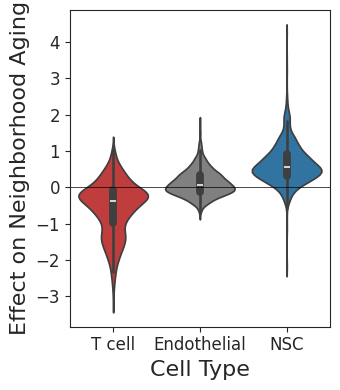

In [11]:
# final plot
celltypes = ["T cell", "Endothelial","NSC"]
palette = {
    "T cell": "tab:red",
    "Endothelial": "0.5",
    "NSC": "tab:blue"
}

#-----------------------------------------------------
pert_effects_col = []
celltype_col = []

for celltype in celltypes:
    
    # read in data
    fn = f"results/gnn/{train_dataset.processed_dir.split('/')[-2]}_perturbedNO{celltype}_ablation.csv"
    df = pd.read_csv(fn)
    
    # subset into networks centered on celltype
    df = df[df["celltype_original"]==celltype].copy()
    
    # compute perturbation effect
    df["perturbation_effect"] = df["predicted_perturbed"]-df["predicted_original"]
    pert_effects_col.append(df["perturbation_effect"].values)
    celltype_col.append(df["celltype_original"].values)

# concatenate
pert_effects_col = np.concatenate(pert_effects_col)
celltype_col = np.concatenate(celltype_col)
    
# make dataframe
plotdf = pd.DataFrame([])
plotdf["perturbation_effect"] = pert_effects_col
plotdf["celltype"] = celltype_col

# make plot
plt.figure(figsize=(3.5,4))
sns.violinplot(data=plotdf, x="celltype", y="perturbation_effect", hue="celltype", palette=palette)
plt.axhline(0, color='k', linewidth=0.5)
plt.ylabel("Effect on Neighborhood Aging", fontsize=16)
plt.xlabel("Cell Type", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/gnn/{train_dataset.processed_dir.split('/')[-2]}_PERTURB_ablation.pdf",
            bbox_inches='tight', dpi=300)
plt.show()